In [58]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## The Model: Budget Gridlock in Two-Party Systems

We model budget negotiations between two parties competing over time. The key ingredients:

### The Players

- **Two parties**: Democrats and Republicans, dividing a budget of size 1
- **Time**: Discrete periods $t = 0, 1, 2, \ldots$ (think: budget cycles)

### Key Variables

| Symbol | Meaning | Example |
|--------|---------|---------|
| $X_t$ | Political state (Democratic strength) | $X_t = 0.6$ means Democrats control 60% of power |
| $\pi_t^i$ | Budget allocation to party $i$ | $\pi_t^{Dem} = 0.55$ means 55% goes to Democratic priorities |
| $U^i(\pi)$ | Utility function for party $i$ | How happy party $i$ is with allocation $\pi$ |
| $\delta$ | Discount factor | $\delta = 0.95$ means future payoffs are worth 95% of today's |

### Two Critical Assumptions

**1. Concave Utility (Risk Aversion)**

Parties prefer stable, moderate outcomes over boom-bust cycles:
$$U^i(0.5) > \frac{1}{2} \cdot U^i(0) + \frac{1}{2} \cdot U^i(1)$$

A guaranteed 50% share is worth more than a coin flip between 0% and 100%.

**2. Commitment Problem**

Parties **cannot** credibly promise future behavior. Today's agreement doesn't bind tomorrow's majority. This is the root cause of gridlock.

# Modeling the strength

The first critical part is to model the strength, X_t, over time. It is a critical assumption that the strength follows a Markov process. This means that the future strength only depends on the current strength and not on the past strengths. It further assumes that the actions, the choice of $\pi$, does not influence the transition of the strength:

$$X_{t+1} = X_t + \epsilon_t$$

where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ represents random shocks (elections, scandals, policy successes/failures). The strength is bounded: $X_t \in [0, 1]$ (reflecting that no party can have negative power or more than total power).

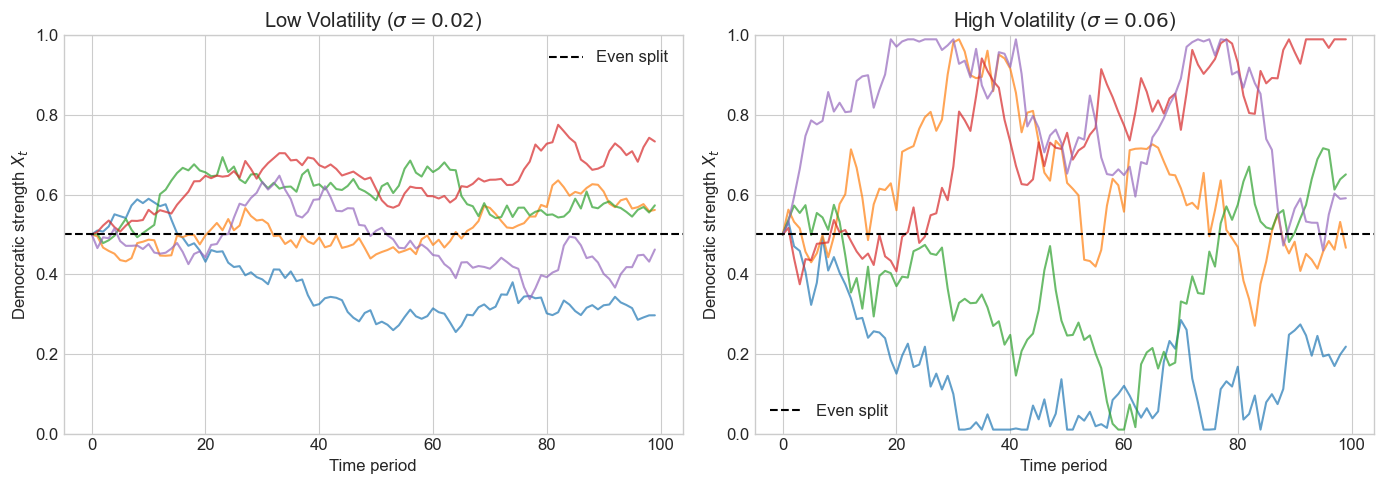

In [59]:
def simulate_political_strength(
    initial_strength: float,
    volatility: float,
    n_periods: int,
    seed: Optional[int] = None,
) -> np.ndarray:
    """
    Simulate the evolution of political strength over time.

    Parameters:
    -----------
    initial_strength : float
        Starting political strength (0 to 1)
    volatility : float
        Standard deviation of random shocks
    n_periods : int
        Number of time periods to simulate
    seed : int, optional
        Random seed for reproducibility

    Returns:
    --------
    np.ndarray : Array of political strength values
    """
    if seed is not None:
        np.random.seed(seed)

    strength = np.zeros(n_periods)
    strength[0] = initial_strength

    for t in range(1, n_periods):
        shock = np.random.normal(0, volatility)
        strength[t] = np.clip(strength[t - 1] + shock, 0.01, 0.99)

    return strength


# Demonstrate the Markov process
np.random.seed(42)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Low volatility
for i in range(5):
    s = simulate_political_strength(0.5, 0.02, 100)
    axes[0].plot(s, alpha=0.7)
axes[0].axhline(0.5, color="black", linestyle="--", label="Even split")
axes[0].set_xlabel("Time period")
axes[0].set_ylabel("Democratic strength $X_t$")
axes[0].set_title("Low Volatility ($\\sigma = 0.02$)")
axes[0].set_ylim(0, 1)
axes[0].legend()

# High volatility
for i in range(5):
    s = simulate_political_strength(0.5, 0.06, 100)
    axes[1].plot(s, alpha=0.7)
axes[1].axhline(0.5, color="black", linestyle="--", label="Even split")
axes[1].set_xlabel("Time period")
axes[1].set_ylabel("Democratic strength $X_t$")
axes[1].set_title("High Volatility ($\\sigma = 0.06$)")
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()

### Strategy: The Mapping from State to Allocation

The key object we're analyzing is the **strategy** $\sigma^i: [0,1] \to [0,1]$, which maps each political state $X_t$ to an allocation $\pi_t^i$.

**Notation:** We typically write $\pi^i(X_t)$ for party $i$'s allocation as a function of the state.

### Naive Strategies as Benchmarks

Before finding the optimal strategy, consider some simple alternatives:

| Strategy | Formula | Interpretation |
|----------|---------|----------------|
| **Proportional** | $\pi^{Dem}(X_t) = X_t$ | "Fair share" — you get what your strength justifies |
| **Winner-Takes-All** | $\pi^{Dem}(X_t) = \begin{cases} 1 & \text{if } X_t > 0.5 \\ 0 & \text{otherwise} \end{cases}$ | Dictatorial — majority party gets everything |
| **Fifty-Fifty** | $\pi^{Dem}(X_t) = 0.5$ | Compromise — always split evenly, ignore strength |
| **Status Quo** | $\pi^{Dem}(X_t) = \pi_{t-1}^{Dem}$ | Inertia — never change past allocation |

**None of these are equilibrium strategies!** Each fails the self-enforcement constraint:
- **Proportional**: When strong, you'd rather grab more (knowing your strength might decline)
- **Winner-Takes-All**: Minority party would deviate (blocking, filibuster, shutdown)
- **Fifty-Fifty**: Ignores political reality — strong party won't accept it
- **Status Quo**: Not credible after regime change

The **equilibrium strategy** must balance what you can demand today against the risk of future retaliation.

In [60]:
# Define four naive strategies for Democratic allocation

def strategy_proportional(X_t: float) -> float:
    """
    Proportional strategy: allocation equals strength.
    π^Dem(X_t) = X_t
    
    "Fair share" — you get what your strength justifies.
    """
    return X_t


def strategy_winner_takes_all(X_t: float) -> float:
    """
    Winner-takes-all strategy: majority gets everything.
    π^Dem(X_t) = 1 if X_t > 0.5, else 0
    
    Dictatorial — majority party gets 100%.
    """
    return 1.0 if X_t > 0.5 else 0.0


def strategy_fifty_fifty(X_t: float) -> float:
    """
    Fifty-fifty strategy: always split evenly.
    π^Dem(X_t) = 0.5
    
    Compromise — ignore political strength entirely.
    """
    return 0.5


def strategy_status_quo(X_t: float, prev_allocation: float = 0.5) -> float:
    """
    Status quo strategy: never change allocation.
    π^Dem(X_t) = π_{t-1}
    
    Inertia — maintain previous allocation regardless of strength.
    
    Note: This requires state (previous allocation), so it's not purely Markovian.
    """
    return prev_allocation


# Test the strategies
X_test = 0.65
print(f"When Democratic strength X_t = {X_test}:")
print(f"  Proportional:      π = {strategy_proportional(X_test):.2f}")
print(f"  Winner-Takes-All:  π = {strategy_winner_takes_all(X_test):.2f}")
print(f"  Fifty-Fifty:       π = {strategy_fifty_fifty(X_test):.2f}")
print(f"  Status Quo:        π = {strategy_status_quo(X_test, 0.45):.2f} (prev=0.45)")


When Democratic strength X_t = 0.65:
  Proportional:      π = 0.65
  Winner-Takes-All:  π = 1.00
  Fifty-Fifty:       π = 0.50
  Status Quo:        π = 0.45 (prev=0.45)


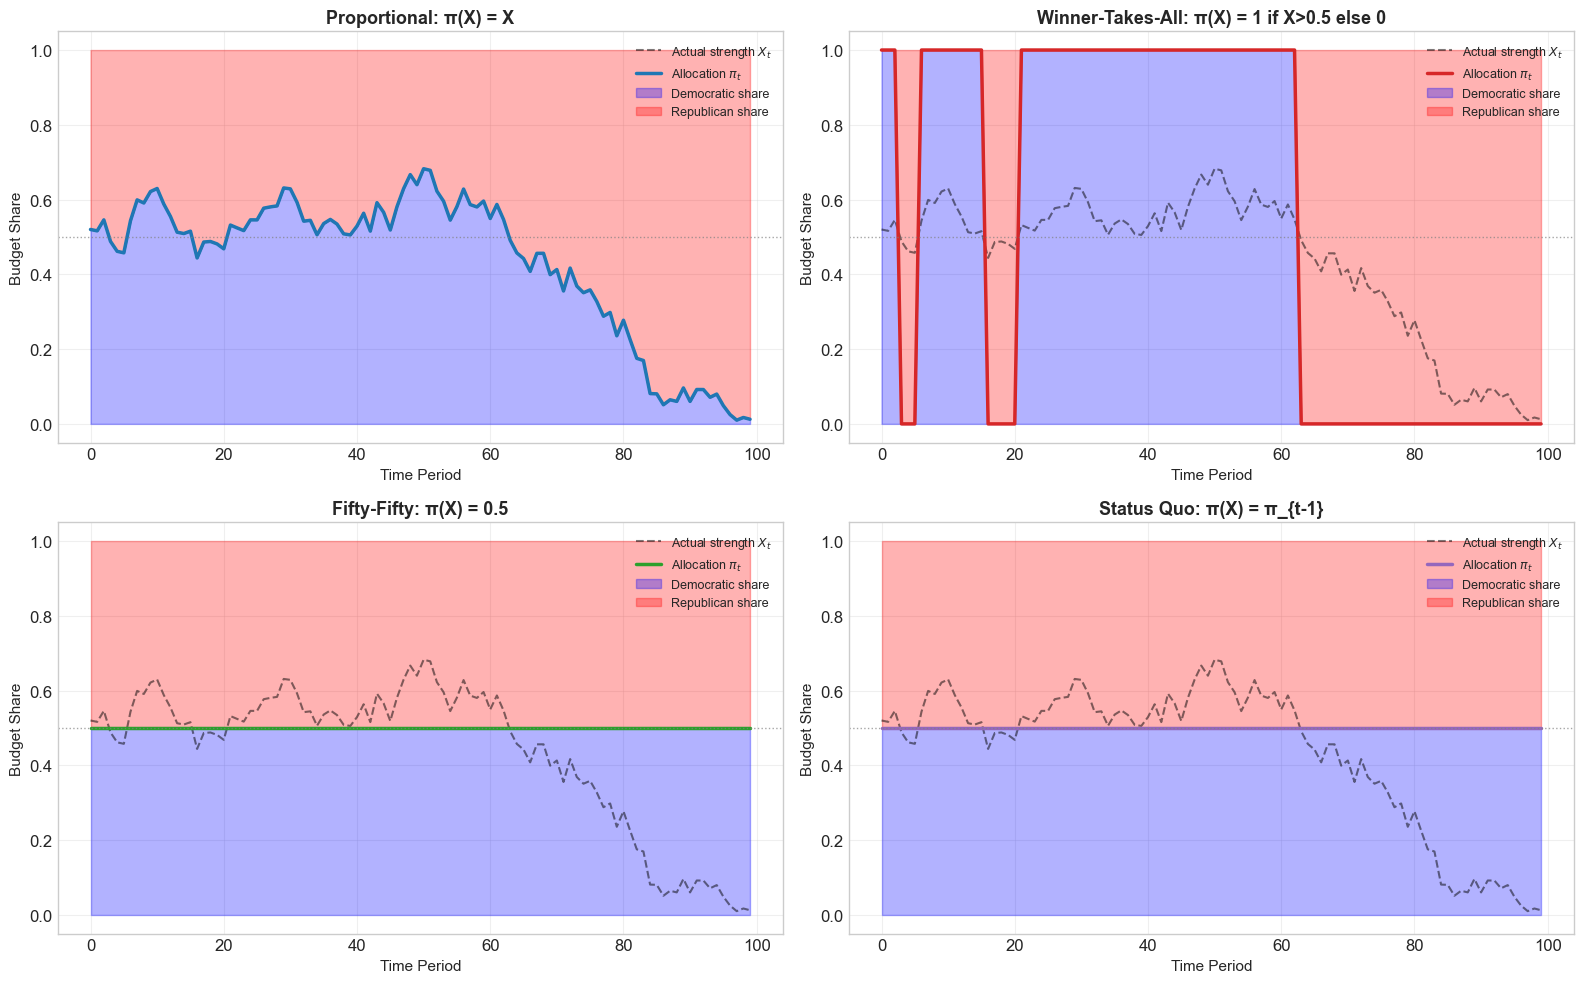


Summary Statistics for Democratic Allocation:

Proportional:
  Mean allocation:      0.434
  Std deviation:        0.193
  Mean strength:        0.434
  Avg gap from strength: 0.000

Winner-Takes-All:
  Mean allocation:      0.550
  Std deviation:        0.497
  Mean strength:        0.434
  Avg gap from strength: 0.358

Fifty-Fifty:
  Mean allocation:      0.500
  Std deviation:        0.000
  Mean strength:        0.434
  Avg gap from strength: 0.142

Status Quo:
  Mean allocation:      0.500
  Std deviation:        0.000
  Mean strength:        0.434
  Avg gap from strength: 0.142


In [61]:
# Visualize the four strategies over a single history of states

# Generate a single trajectory of political strength
np.random.seed(2025)
n_periods = 100
strength_history = simulate_political_strength(
    initial_strength=0.52, 
    volatility=0.04, 
    n_periods=n_periods
)

# Apply each strategy to the history
times = np.arange(n_periods)
alloc_proportional = np.array([strategy_proportional(X) for X in strength_history])
alloc_winner_takes_all = np.array([strategy_winner_takes_all(X) for X in strength_history])
alloc_fifty_fifty = np.array([strategy_fifty_fifty(X) for X in strength_history])

# Status quo requires tracking previous allocation
alloc_status_quo = np.zeros(n_periods)
alloc_status_quo[0] = 0.5  # Initial allocation
for t in range(1, n_periods):
    alloc_status_quo[t] = strategy_status_quo(strength_history[t], alloc_status_quo[t-1])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

strategies = [
    ("Proportional: π(X) = X", alloc_proportional, 'tab:blue'),
    ("Winner-Takes-All: π(X) = 1 if X>0.5 else 0", alloc_winner_takes_all, 'tab:red'),
    ("Fifty-Fifty: π(X) = 0.5", alloc_fifty_fifty, 'tab:green'),
    ("Status Quo: π(X) = π_{t-1}", alloc_status_quo, 'tab:purple')
]

for idx, (title, allocation, color) in enumerate(strategies):
    ax = axes[idx // 2, idx % 2]
    
    # Plot actual strength as reference
    ax.plot(times, strength_history, 'k--', linewidth=1.5, alpha=0.5, label='Actual strength $X_t$')
    
    # Plot allocation from strategy
    ax.plot(times, allocation, color=color, linewidth=2.5, label='Allocation $\\pi_t$')
    
    # Fill area showing Democrat vs Republican shares
    ax.fill_between(times, 0, allocation, alpha=0.3, color='blue', label='Democratic share')
    ax.fill_between(times, allocation, 1, alpha=0.3, color='red', label='Republican share')
    
    # Add 50% reference line
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Time Period', fontsize=11)
    ax.set_ylabel('Budget Share', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate summary statistics
print("\nSummary Statistics for Democratic Allocation:")
print("="*60)
for name, allocation, _ in strategies:
    mean_alloc = np.mean(allocation)
    std_alloc = np.std(allocation)
    mean_strength = np.mean(strength_history)
    gap = np.mean(np.abs(allocation - strength_history))
    
    print(f"\n{name.split(':')[0]}:")
    print(f"  Mean allocation:      {mean_alloc:.3f}")
    print(f"  Std deviation:        {std_alloc:.3f}")
    print(f"  Mean strength:        {mean_strength:.3f}")
    print(f"  Avg gap from strength: {gap:.3f}")


# The utility

### What is $U^i$? How Happy You Are With Your Slice

Here's the crucial insight: **doubling your budget share doesn't double your party's welfare**.

Think about it in political terms:
- Going from **10% to 20%** of the budget (doubling!) = Transformative! You can finally fund core priorities
- Going from **50% to 100%** (also doubling!) = Nice, but diminishing returns — most important programs are already funded

The utility function $U^i(\pi)$ captures this non-linearity. It translates "budget share you control" into "political value you extract."

**Why this matters for negotiations:** A party controlling 30% values an additional 10% far more than a party controlling 70% values the same 10%. This creates natural pressure for compromise—in theory.

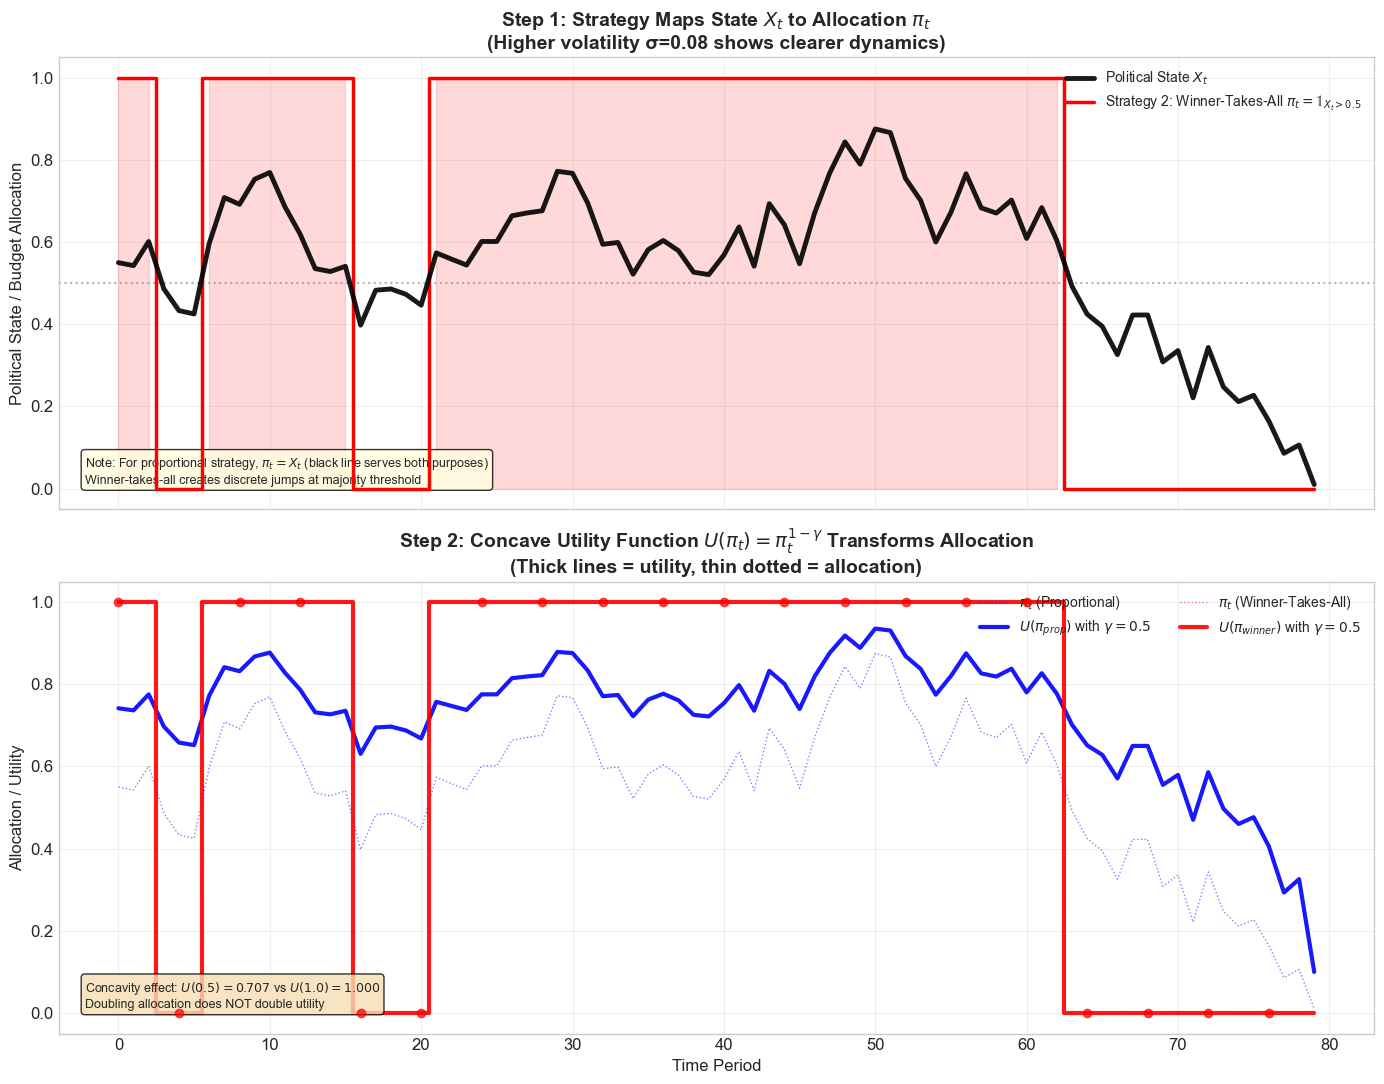


COMPARING TWO STRATEGIES ON THE SAME STATE HISTORY

Risk aversion parameter: γ = 0.5
Volatility: σ = 0.08 (higher than before for better visualization)
History length: 80 periods

Mean political strength: 0.550
Std political strength:  0.181
Periods with Dem majority (X_t > 0.5): 55/80

--- PROPORTIONAL STRATEGY: π(X) = X ---
Mean allocation:     0.550
Std allocation:      0.181
Mean utility:        0.727
Std utility:         0.148

--- WINNER-TAKES-ALL STRATEGY: π(X) = 𝟙[X > 0.5] ---
Mean allocation:     0.688
Std allocation:      0.464
Mean utility:        0.688
Std utility:         0.464


In [62]:
# Connecting Strategy → Allocation → Utility

def utility_crra(pi: np.ndarray, gamma: float) -> np.ndarray:
    """
    Constant Relative Risk Aversion (CRRA) utility function.
    U(π) = π^(1-gamma) for gamma != 1
    U(π) = log(π) for gamma = 1
    
    Parameters:
    -----------
    pi : np.ndarray
        Budget allocation (0 to 1)
    gamma : float
        Risk aversion parameter (0 = risk neutral, higher = more risk averse)
    
    Returns:
    --------
    np.ndarray : Utility values
    """
    if gamma == 1:
        # Log utility
        return np.log(np.maximum(pi, 1e-10))  # Avoid log(0)
    else:
        return pi ** (1 - gamma)


# Generate a single history of political strength with HIGHER VOLATILITY for better visualization
np.random.seed(2025)
n_periods = 80
strength_history = simulate_political_strength(0.55, 0.08, n_periods)  # Increased from 0.04 to 0.08

# Apply two different strategies to the same state history
times = np.arange(n_periods)
alloc_proportional = np.array([strategy_proportional(X) for X in strength_history])
alloc_winner_takes_all = np.array([strategy_winner_takes_all(X) for X in strength_history])

# Calculate utilities for each strategy (with gamma = 0.5)
gamma = 0.5
utility_proportional = utility_crra(alloc_proportional, gamma)
utility_winner = utility_crra(alloc_winner_takes_all, gamma)

# Visualization: Two-step process with improved clarity
fig, axes = plt.subplots(2, 1, figsize=(14, 11), sharex=True)

# ============================================================================
# Plot 1: STATE → ALLOCATION (Strategy in action)
# ============================================================================
ax1 = axes[0]

# Plot the political state (thicker line)
ax1.plot(times, strength_history, 'k-', linewidth=3.5, alpha=0.9, label='Political State $X_t$', zorder=10)

# For proportional strategy: state = allocation, so we just add note in legend
# Plot winner-takes-all allocation with distinct style
ax1.step(times, alloc_winner_takes_all, 'r-', linewidth=2.5, where='mid', 
         label='Strategy 2: Winner-Takes-All $\\pi_t = \\mathbb{1}_{X_t > 0.5}$', zorder=5)

# Add shading to show the "jump" regions for winner-takes-all
majority_periods = alloc_winner_takes_all > 0.5
ax1.fill_between(times, 0, 1, where=majority_periods, alpha=0.15, color='red', step='mid')

# Add 50% reference line
ax1.axhline(0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.6)

# Formatting
ax1.set_ylabel('Political State / Budget Allocation', fontsize=12)
ax1.set_title('Step 1: Strategy Maps State $X_t$ to Allocation $\\pi_t$\n(Higher volatility σ=0.08 shows clearer dynamics)', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, alpha=0.3)

# Add annotation showing the strategy function
ax1.text(0.02, 0.05, 'Note: For proportional strategy, $\\pi_t = X_t$ (black line serves both purposes)\nWinner-takes-all creates discrete jumps at majority threshold',
         transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# ============================================================================
# Plot 2: ALLOCATION → UTILITY (Visualizing concave transformation)
# ============================================================================
ax2 = axes[1]

# Use markers to distinguish allocation from utility for winner-takes-all
# Proportional: show allocation as thin line, utility as thick line
ax2.plot(times, alloc_proportional, 'b:', linewidth=1, alpha=0.5, label='$\\pi_t$ (Proportional)')
ax2.plot(times, utility_proportional, 'b-', linewidth=3, alpha=0.9, label=f'$U(\\pi_{{prop}})$ with $\\gamma={gamma}$')

# Winner-takes-all: use markers + step function to show discrete nature
ax2.step(times, alloc_winner_takes_all, 'r:', linewidth=1, alpha=0.5, where='mid',
         label='$\\pi_t$ (Winner-Takes-All)')
ax2.step(times, utility_winner, 'r-', linewidth=3, alpha=0.9, where='mid',
         label=f'$U(\\pi_{{winner}})$ with $\\gamma={gamma}$')
# Add markers to make winner-takes-all utility more visible
winner_markers = times[::4]  # Every 4th point
ax2.plot(winner_markers, utility_winner[::4], 'ro', markersize=6, alpha=0.7, zorder=10)

# Formatting
ax2.set_xlabel('Time Period', fontsize=12)
ax2.set_ylabel('Allocation / Utility', fontsize=12)
ax2.set_title('Step 2: Concave Utility Function $U(\\pi_t) = \\pi_t^{1-\\gamma}$ Transforms Allocation\n(Thick lines = utility, thin dotted = allocation)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10, ncol=2)
ax2.grid(True, alpha=0.3)

# Add annotation showing the concavity effect
ax2.text(0.02, 0.05, f'Concavity effect: $U(0.5) = {0.5**(1-gamma):.3f}$ vs $U(1.0) = {1.0**(1-gamma):.3f}$\nDoubling allocation does NOT double utility',
         transform=ax2.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("COMPARING TWO STRATEGIES ON THE SAME STATE HISTORY")
print("="*70)
print(f"\nRisk aversion parameter: γ = {gamma}")
print(f"Volatility: σ = 0.08 (higher than before for better visualization)")
print(f"History length: {n_periods} periods")
print(f"\nMean political strength: {np.mean(strength_history):.3f}")
print(f"Std political strength:  {np.std(strength_history):.3f}")
print(f"Periods with Dem majority (X_t > 0.5): {np.sum(strength_history > 0.5)}/{n_periods}")

print(f"\n--- PROPORTIONAL STRATEGY: π(X) = X ---")
print(f"Mean allocation:     {np.mean(alloc_proportional):.3f}")
print(f"Std allocation:      {np.std(alloc_proportional):.3f}")
print(f"Mean utility:        {np.mean(utility_proportional):.3f}")
print(f"Std utility:         {np.std(utility_proportional):.3f}")

print(f"\n--- WINNER-TAKES-ALL STRATEGY: π(X) = 𝟙[X > 0.5] ---")
print(f"Mean allocation:     {np.mean(alloc_winner_takes_all):.3f}")
print(f"Std allocation:      {np.std(alloc_winner_takes_all):.3f}")
print(f"Mean utility:        {np.mean(utility_winner):.3f}")
print(f"Std utility:         {np.std(utility_winner):.3f}")

## From utility to expected payoffs over time

Now we have the pieces:
- $X_t$ = political strength (the state)
- $\sigma^i(X_t)$ = strategy (state → allocation)
- $U^i(\pi)$ = utility (how you value today's allocation)

But there's a crucial problem: **budget negotiations don't happen just once**. You're not choosing an allocation for today only—you're choosing a strategy that will govern allocations for years to come.

The **payoff** $V^i$ captures the total value of a strategy over time. Think of it as:
- Utility $U^i(\pi_t)$ = "How happy am I with this year's budget?"
- Payoff $V^i$ = "How happy am I with the entire future stream of budgets?"

Formally, party 1's payoff from strategies $(\sigma^1, \sigma^2)$ starting at state $X_t$ is:

$$V_t^1(\sigma^1, \sigma^2, X_t) = E\left[\sum_{\tau \geq t} \delta^{\tau-t} U^1(\sigma^1(X_\tau)) \mid X_t\right]$$

In [63]:
# Monte Carlo simulation: Compare expected payoffs across four strategies

# Parameters
n_simulations = 300
n_periods = 80
initial_strength = 0.55
volatility = 0.06
gamma = 0.5  # Risk aversion parameter
delta = 0.9  # Discount factor

# Storage for payoffs
payoffs = {
    'proportional': [],
    'winner_takes_all': [],
    'fifty_fifty': [],
    'status_quo': [],
}

# Run simulations
# np.random.seed(42)
for sim in range(n_simulations):
    # Generate one history of political strength
    X_history = simulate_political_strength(initial_strength, volatility, n_periods, seed=None)
    
    # Apply each strategy to this history
    pi_prop = np.array([strategy_proportional(X) for X in X_history])
    pi_winner = np.array([strategy_winner_takes_all(X) for X in X_history])
    pi_fifty = np.array([strategy_fifty_fifty(X) for X in X_history])
    
    # Status quo strategy needs tracking
    pi_status = np.zeros(n_periods)
    pi_status[0] = 0.5
    for t in range(1, n_periods):
        pi_status[t] = strategy_status_quo(X_history[t], pi_status[t-1])
        
    # Calculate utilities for each strategy
    U_prop = utility_crra(pi_prop, gamma)
    U_winner = utility_crra(pi_winner, gamma)
    U_fifty = utility_crra(pi_fifty, gamma)
    U_status = utility_crra(pi_status, gamma)
    
    # Calculate discounted payoffs: V = Σ δ^t U(π_t)
    discount_factors = np.array([delta**t for t in range(n_periods)])
    
    V_prop = np.sum(discount_factors * U_prop)
    V_winner = np.sum(discount_factors * U_winner)
    V_fifty = np.sum(discount_factors * U_fifty)
    V_status = np.sum(discount_factors * U_status)
    
    # Store results
    payoffs['proportional'].append(V_prop)
    payoffs['winner_takes_all'].append(V_winner)
    payoffs['fifty_fifty'].append(V_fifty)
    payoffs['status_quo'].append(V_status)
# Calculate statistics
print("="*70)
print("MONTE CARLO COMPARISON: EXPECTED PAYOFFS FOR FIVE STRATEGIES")
print("="*70)
print(f"\nSimulation parameters:")
print(f"  • Number of histories: {n_simulations}")
print(f"  • Periods per history: {n_periods}")
print(f"  • Initial strength: {initial_strength:.2f}")
print(f"  • Volatility (σ): {volatility:.2f}")
print(f"  • Risk aversion (γ): {gamma}")
print(f"  • Discount factor (δ): {delta}")
print(f"\nPayoff formula: V = Σ δ^t U(π_t), where U(π) = π^(1-γ)")

print("\n" + "-"*70)
print("RESULTS: Expected Payoffs (Discounted Sum of Utilities)")
print("-"*70)

strategies_ordered = [
    ('Proportional: π(X) = X', 'proportional'),
    ('Winner-Takes-All: π(X) = 𝟙[X > 0.5]', 'winner_takes_all'),
    ('Fifty-Fifty: π(X) = 0.5', 'fifty_fifty'),
    ('Status Quo: π(X) = π_{t-1}', 'status_quo'),
]

for label, key in strategies_ordered:
    mean_payoff = np.mean(payoffs[key])
    std_payoff = np.std(payoffs[key])
    print(f"\n{label}")
    print(f"  Mean payoff:  {mean_payoff:.3f}")
    print(f"  Std payoff:   {std_payoff:.3f}")

# Rank strategies by mean payoff
print("\n" + "-"*70)
print("RANKING (by mean payoff):")
print("-"*70)
ranked = sorted(strategies_ordered, key=lambda x: np.mean(payoffs[x[1]]), reverse=True)
for rank, (label, key) in enumerate(ranked, 1):
    mean_payoff = np.mean(payoffs[key])
    print(f"{rank}. {label.split(':')[0]:25s} → {mean_payoff:.3f}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("The high-water mark strategy should perform well because it:")
print("  • Exploits strength when in power (ratchet up)")
print("  • Avoids excessive demands that trigger retaliation")
print("  • Balances current gains with future cooperation")

MONTE CARLO COMPARISON: EXPECTED PAYOFFS FOR FIVE STRATEGIES

Simulation parameters:
  • Number of histories: 300
  • Periods per history: 80
  • Initial strength: 0.55
  • Volatility (σ): 0.06
  • Risk aversion (γ): 0.5
  • Discount factor (δ): 0.9

Payoff formula: V = Σ δ^t U(π_t), where U(π) = π^(1-γ)

----------------------------------------------------------------------
RESULTS: Expected Payoffs (Discounted Sum of Utilities)
----------------------------------------------------------------------

Proportional: π(X) = X
  Mean payoff:  7.332
  Std payoff:   0.854

Winner-Takes-All: π(X) = 𝟙[X > 0.5]
  Mean payoff:  6.872
  Std payoff:   2.867

Fifty-Fifty: π(X) = 0.5
  Mean payoff:  7.070
  Std payoff:   0.000

Status Quo: π(X) = π_{t-1}
  Mean payoff:  7.070
  Std payoff:   0.000

----------------------------------------------------------------------
RANKING (by mean payoff):
----------------------------------------------------------------------
1. Proportional              → 7.332

If you play around a bit you can see that the discount factor $\delta$ plays a crucial role here. If you are super impatient and future outcomes barely matter (low $\delta$), then the winner-takes-all strategy becomes optimal. On the other hand, if you are very patient and care a lot about future outcomes (high $\delta$), then more moderate strategies that avoid gridlock become optimal.

# And the optimimum ?


## The Critical Allocation $Y^*(X_0)$

A key object in the analysis is **the minimum initial allocation that keeps cooperation viable**.

**Definition:** Let $Y^*(X_0)$ be the initial allocation to the minority party (party not in power) that makes the party in power **exactly indifferent** between:
- **Cooperating**: Accept $Y^*(X_0)$ and continue cooperation
- **Deviating**: Grab 100% now and face winner-takes-all forever

Formally, if party $i$ is in power, then:
$$V^i_t(\rho^*, h_t) = V^i_t(\bar{\rho}, h_t)$$

**In plain English:** $Y^*(X_0)$ is the **binding minimum share**. Give the minority any less, and the majority says "forget cooperation, I'll just take everything." 

It is actually important to note that the calculation of the exact value of $Y^*(X_0)$ is fairly non trivial and even avoided in the original paper and the  chapter 23 by Acemoglu. However, its existence and properties are sufficient for our purposes.

## The high-water mark strategy
The problem is actually set up in a way that we can find some cute analytical solutions.  A strategy $\rho$ is efficient if and only if **the allocations $Y$ it generates** satisfy:

**(i) Initial condition:**
$$Y(X_0) \begin{cases} \geq Y^*(X_0) & \text{if } X_0 \in S_1 \text{ (party 1 in power)} \\ \leq Y^*(X_0) & \text{if } X_0 \in S_2 \text{ (party 2 in power)} \end{cases}$$

**(ii) Evolution rule (the ratchet):**
$$Y(X_t) = \begin{cases} \max[Y^*(X_t), Y(X_{t-1})] & \text{if } X_t \in S_1 \\ \min[Y^*(X_t), Y(X_{t-1})] & \text{if } X_t \in S_2 \end{cases}$$

for all $t \geq 1$.

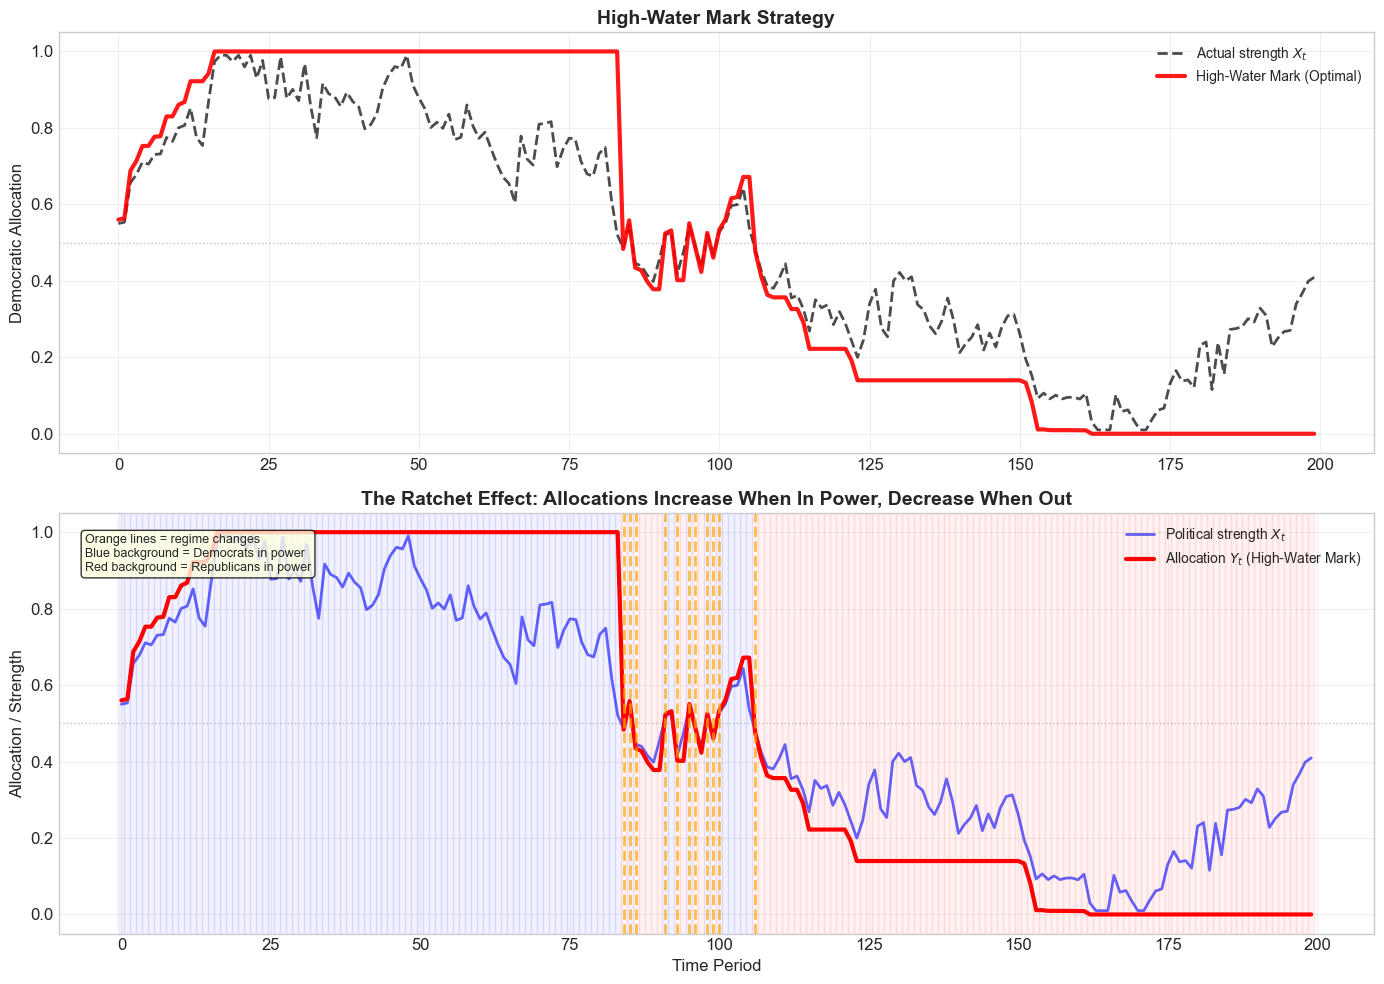

In [70]:
def calculate_Y_star_simplified(X_t: float, delta: float = 0.9, gamma: float = 0.5) -> float:
    """
    Simplified Y*(X_t) - the binding minimum allocation given that it quite hard to calculate exactly.
    So the values here are illustrative approximations.
    
    This approximation uses the idea that Y* must be high enough that
    the party in power prefers cooperation over winner-takes-all.
    
    For simplicity, we use: Y*(X) ≈ X + adjustment based on being in power
    This ensures the minority gets slightly more than proportional share
    to keep cooperation viable.
    
    Parameters:
    -----------
    X_t : float
        Current political strength (0 to 1)
    delta : float
        Discount factor (patience parameter)
    gamma : float
        Risk aversion parameter
    
    Returns:
    --------
    float : Binding minimum allocation Y*(X_t)
    """
    # If Democrats in power (X_t > 0.5), Y* is for themselves
    # If Republicans in power (X_t < 0.5), Y* is for themselves (1 - X_t)
    
    # Simplified approximation: Y* slightly favors the majority party
    # but gives minority more than they'd get under winner-takes-all
    deltaX = X_t - 0.5
    Ystar = 1/2 + 1.2*deltaX
    if Ystar < 0:
        return 0.0
    elif Ystar > 1:
        return 1.0
    return Ystar

def strategy_high_water_mark(
    X_history: np.ndarray, 
    delta: float = 0.9, 
    gamma: float = 0.5
) -> np.ndarray:
    """
    Efficient high-water mark strategy from Proposition 23.1.
    
    Implements the ratchet rule:
    - Initial condition: Y(X_0) ≥ Y*(X_0) if party 1 in power
    - Evolution: Y_t = max[Y*(X_t), Y_{t-1}] if in power
    -            Y_t = min[Y*(X_t), Y_{t-1}] if out of power
    
    Parameters:
    -----------
    X_history : np.ndarray
        History of political strength values
    delta : float
        Discount factor
    gamma : float
        Risk aversion parameter
    
    Returns:
    --------
    np.ndarray : Democratic allocations following high-water mark rule
    """
    n_periods = len(X_history)
    Y_allocations = np.zeros(n_periods)
    
    # Initial allocation based on Y*(X_0)
    X_0 = X_history[0]
    Y_star_0 = calculate_Y_star_simplified(X_0, delta, gamma)
    
    if X_0 > 0.5:
        # Democrats in power - start at Y*(X_0)
        Y_allocations[0] = Y_star_0
    else:
        # Republicans in power - Democrats get less
        Y_allocations[0] = Y_star_0
    
    # Track who's in power
    in_dem_power = X_0 > 0.5
    
    # Apply evolution rule
    for t in range(1, n_periods):
        X_t = X_history[t]
        Y_star_t = calculate_Y_star_simplified(X_t, delta, gamma)
        
        current_in_dem_power = X_t > 0.5
        
        # Check for regime change
        if current_in_dem_power != in_dem_power:
            # Regime change - reset to Y*(X_t)
            Y_allocations[t] = Y_star_t
            in_dem_power = current_in_dem_power
        else:
            # Same regime - apply ratchet rule
            if in_dem_power:
                # Democrats in power - can only increase (or stay same)
                Y_allocations[t] = max(Y_star_t, Y_allocations[t-1])
            else:
                # Republicans in power - Democrats can only decrease (or stay same)
                Y_allocations[t] = min(Y_star_t, Y_allocations[t-1])
    
    return Y_allocations


# Visualize the high-water mark strategy on a sample history
# np.random.seed(2025)
n_steps = 200
test_history = simulate_political_strength(0.55, 0.06, n_steps)

# High-water mark
alloc_hwm = strategy_high_water_mark(test_history, delta=0.9, gamma=0.5)

# Visualize comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

times = np.arange(n_steps)

# Plot 1: All strategies vs actual strength
ax1 = axes[0]
ax1.plot(times, test_history, 'k--', linewidth=2, alpha=0.7, label='Actual strength $X_t$')
ax1.plot(times, alloc_hwm, 'r-', linewidth=3, alpha=0.9, label='High-Water Mark (Optimal)')

ax1.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_ylabel('Democratic Allocation', fontsize=12)
ax1.set_title('High-Water Mark Strategy', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Focus on high-water mark mechanism
ax2 = axes[1]
ax2.plot(times, test_history, 'b-', linewidth=2, alpha=0.6, label='Political strength $X_t$')
ax2.plot(times, alloc_hwm, 'r-', linewidth=3, label='Allocation $Y_t$ (High-Water Mark)')

# Highlight regime changes
regime = test_history > 0.5
regime_changes = np.where(regime[1:] != regime[:-1])[0] + 1
for rc in regime_changes:
    ax2.axvline(rc, color='orange', linestyle='--', linewidth=2, alpha=0.7)

# Shade by regime
for i in range(len(times)):
    if regime[i]:
        ax2.axvspan(i-0.5, i+0.5, alpha=0.05, color='blue')
    else:
        ax2.axvspan(i-0.5, i+0.5, alpha=0.05, color='red')

ax2.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_xlabel('Time Period', fontsize=12)
ax2.set_ylabel('Allocation / Strength', fontsize=12)
ax2.set_title('The Ratchet Effect: Allocations Increase When In Power, Decrease When Out', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add annotation
ax2.text(0.02, 0.95, 
         'Orange lines = regime changes\nBlue background = Democrats in power\nRed background = Republicans in power',
         transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

## Part 2: The Commitment Problem

### Why Can't Parties Just Agree?

Here's the key insight from Acemoglu and the DGG model: **parties cannot credibly commit to future behavior**.

Imagine Democrats are at 60% strength today. Republicans might offer: "Accept 40% of the budget now, and when we're stronger, we'll give you a fair deal."

But Democrats know:
1. When Republicans are stronger, they'll demand *more*, not honor past promises
2. Accepting less now signals weakness, affecting future negotiations
3. There's no enforcement mechanism for promises about future budgets

This is Acemoglu's central point:

> *"The heart of the difficulty is a commitment problem—it can be hard for political leaders to keep their promises."*